#### Imports

In [1]:
import keras
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb

Using TensorFlow backend.


In [2]:
%matplotlib inline

#### SHAP Initialization

In [3]:
use_shap = True

In [4]:
# load JS visualization code to notebook
if use_shap:
    shap.initjs()

#### Train and Test Files

In [5]:
pwd

'C:\\Users\\t0272m1\\Projects\\HR Analytics'

In [6]:
path = 'C:/Users/t0272m1/Projects/HR Analytics/input/'

In [35]:
train_file = '\\'.join([path, 'train.csv'])
df_train = pd.read_csv(train_file)

In [36]:
test_file = '\\'.join([path, 'test.csv'])
df_test = pd.read_csv(test_file)

In [37]:
df_train.shape, df_test.shape

((44841, 55), (10872, 55))

#### Data Subsets

In [11]:
subset_limit = 1.0
df_train = df_train[df_train['snow_depth'] >= subset_limit]
df_test = df_test[df_test['snow_depth'] >= subset_limit]

In [12]:
df_train.shape, df_test.shape

((6375, 52), (1920, 52))

#### Exploratory

In [10]:
for f in df_train.columns:
    print(f, df_train[f].dtype)

workdate object
crew object
production_line object
group_total float64
lost_hours float64
actual_hours float64
paa_hours float64
absences_late float64
absences_noshow float64
absences_any float64
mean_absence_pct float64
mean_experience float64
absences_planned float64
home_canvasses float64
absences_fmla float64
peia_count int64
tpt_count float64
streak_1 float64
streak_2 float64
streak_3 float64
streak_4_plus float64
cluster float64
au_rolling_5 float64
au_rolling_12 float64
au_rolling_20 float64
au_rolling_median_5 float64
au_rolling_median_12 float64
au_rolling_median_20 float64
actual_hours_rolling_mean_20 float64
actual_hours_rolling_median_20 float64
lost_hours_rolling_mean_20 float64
lost_hours_rolling_median_20 float64
tpt_unplanned float64
tpt_extra float64
kp_residual_5 float64
kp_residual_12 float64
kp_residual_20 float64
year int64
month int64
week int64
day int64
day_of_week int64
day_of_year int64
quarter int64
next_day_delta float64
precip float64
snowfall float64
snow_

In [11]:
df_train.columns = df_train.columns.str.replace('[', '_').str.replace(']', '')
df_test.columns = df_test.columns.str.replace('[', '_').str.replace(']', '')

In [12]:
df_train.columns

Index(['workdate', 'crew', 'production_line', 'group_total', 'lost_hours',
       'actual_hours', 'paa_hours', 'absences_late', 'absences_noshow',
       'absences_any', 'mean_absence_pct', 'mean_experience',
       'absences_planned', 'home_canvasses', 'absences_fmla', 'peia_count',
       'tpt_count', 'streak_1', 'streak_2', 'streak_3', 'streak_4_plus',
       'cluster', 'au_rolling_5', 'au_rolling_12', 'au_rolling_20',
       'au_rolling_median_5', 'au_rolling_median_12', 'au_rolling_median_20',
       'actual_hours_rolling_mean_20', 'actual_hours_rolling_median_20',
       'lost_hours_rolling_mean_20', 'lost_hours_rolling_median_20',
       'tpt_unplanned', 'tpt_extra', 'kp_residual_5', 'kp_residual_12',
       'kp_residual_20', 'year', 'month', 'week', 'day', 'day_of_week',
       'day_of_year', 'quarter', 'next_day_delta', 'precip', 'snowfall',
       'snow_depth', 'temp_avg', 'temp_max', 'temp_min', 'fog', 'temp_delta',
       'nth_kday', 'absences_unplanned'],
      dtype='obje

In [38]:
df_train['crew'], _ = pd.factorize(df_train['crew'])
df_test['crew'], _ = pd.factorize(df_test['crew'])
df_train['production_line'], _ = pd.factorize(df_train['production_line'])
df_test['production_line'], _ = pd.factorize(df_test['production_line'])

In [39]:
df_train['crew'].unique()

array([0, 1, 2], dtype=int64)

In [ ]:
df_train['team'], _ = pd.factorize(df_train['team'])
df_test['team'], _ = pd.factorize(df_test['team'])

#### XGBoost Training

In [41]:
target = 'absences_unplanned'
y_train = df_train[target]
y_test = df_test[target]

In [42]:
use_subset = False
if use_subset:   
    features = ['precip', 'snowfall', 'snow_depth', 'temp_avg', 'temp_max', 'temp_min', 'fog']
    dtrain = xgb.DMatrix(df_train[features], y_train)
    dtest = xgb.DMatrix(df_test[features], y_test)
else:
    exclude_cols = ['workdate', 'absences_unplanned']
    df_train.drop(columns=exclude_cols, inplace=True)
    df_test.drop(columns=exclude_cols, inplace=True)
    dtrain = xgb.DMatrix(df_train, y_train)
    dtest = xgb.DMatrix(df_test, y_test)    

In [47]:
params = {
    "objective": "reg:linear",
    "booster" : "gbtree",
    "eval_metric": "mae",
    "eta": 0.01,
    "tree_method": 'exact',
    "max_depth": 4,
    "subsample": 1,
    "colsample_bytree": 1,
    "silent": 1,
    "min_chil_weight": 1,
    "seed": 42
}

num_rounds = 500
early_stopping_rounds = 30

In [48]:
# train XGBoost model
eval_set = [(dtrain, 'train'), (dtest, 'eval')]
gbm = xgb.train(params, dtrain, num_rounds, evals=eval_set, early_stopping_rounds=early_stopping_rounds)

[0]	train-mae:4.18701	eval-mae:4.59073
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 30 rounds.
[1]	train-mae:4.14839	eval-mae:4.5473
[2]	train-mae:4.11015	eval-mae:4.50426
[3]	train-mae:4.07231	eval-mae:4.46167
[4]	train-mae:4.03481	eval-mae:4.41957
[5]	train-mae:3.99796	eval-mae:4.37787
[6]	train-mae:3.96127	eval-mae:4.33656
[7]	train-mae:3.92512	eval-mae:4.29621
[8]	train-mae:3.88937	eval-mae:4.25632
[9]	train-mae:3.85405	eval-mae:4.21671
[10]	train-mae:3.81933	eval-mae:4.17785
[11]	train-mae:3.78492	eval-mae:4.13924
[12]	train-mae:3.75091	eval-mae:4.10121
[13]	train-mae:3.71725	eval-mae:4.06361
[14]	train-mae:3.68411	eval-mae:4.02667
[15]	train-mae:3.65153	eval-mae:3.99007
[16]	train-mae:3.61926	eval-mae:3.9541
[17]	train-mae:3.58743	eval-mae:3.91855
[18]	train-mae:3.55606	eval-mae:3.88335
[19]	train-mae:3.52498	eval-mae:3.84868
[20]	train-mae:3.49435	eval-mae:3.81431
[21]	train-mae:3.46412	eval-mae

[200]	train-mae:1.69567	eval-mae:1.82173
[201]	train-mae:1.6944	eval-mae:1.82048
[202]	train-mae:1.69294	eval-mae:1.8192
[203]	train-mae:1.69167	eval-mae:1.81799
[204]	train-mae:1.6904	eval-mae:1.8167
[205]	train-mae:1.68905	eval-mae:1.81542
[206]	train-mae:1.68789	eval-mae:1.81429
[207]	train-mae:1.68662	eval-mae:1.81308
[208]	train-mae:1.68558	eval-mae:1.81199
[209]	train-mae:1.68427	eval-mae:1.81086
[210]	train-mae:1.68319	eval-mae:1.80986
[211]	train-mae:1.68198	eval-mae:1.80874
[212]	train-mae:1.681	eval-mae:1.80782
[213]	train-mae:1.67999	eval-mae:1.80691
[214]	train-mae:1.67883	eval-mae:1.80589
[215]	train-mae:1.6778	eval-mae:1.805
[216]	train-mae:1.67682	eval-mae:1.8042
[217]	train-mae:1.67589	eval-mae:1.80331
[218]	train-mae:1.67495	eval-mae:1.80233
[219]	train-mae:1.67402	eval-mae:1.80156
[220]	train-mae:1.67313	eval-mae:1.80072
[221]	train-mae:1.67222	eval-mae:1.80003
[222]	train-mae:1.67137	eval-mae:1.79923
[223]	train-mae:1.67039	eval-mae:1.79835
[224]	train-mae:1.66953	ev

[402]	train-mae:1.61362	eval-mae:1.76307
[403]	train-mae:1.61342	eval-mae:1.76301
[404]	train-mae:1.61333	eval-mae:1.76301
[405]	train-mae:1.61322	eval-mae:1.76313
[406]	train-mae:1.61312	eval-mae:1.76309
[407]	train-mae:1.61303	eval-mae:1.76303
[408]	train-mae:1.61293	eval-mae:1.76293
[409]	train-mae:1.61284	eval-mae:1.76296
[410]	train-mae:1.61274	eval-mae:1.76288
[411]	train-mae:1.61265	eval-mae:1.76286
[412]	train-mae:1.61255	eval-mae:1.76274
[413]	train-mae:1.61245	eval-mae:1.76271
[414]	train-mae:1.61227	eval-mae:1.76268
[415]	train-mae:1.61217	eval-mae:1.76261
[416]	train-mae:1.61206	eval-mae:1.76272
[417]	train-mae:1.61194	eval-mae:1.76275
[418]	train-mae:1.61184	eval-mae:1.76269
[419]	train-mae:1.61169	eval-mae:1.7627
[420]	train-mae:1.61159	eval-mae:1.76264
[421]	train-mae:1.61149	eval-mae:1.76261
[422]	train-mae:1.61131	eval-mae:1.76259
[423]	train-mae:1.61122	eval-mae:1.76251
[424]	train-mae:1.61113	eval-mae:1.76249
[425]	train-mae:1.61094	eval-mae:1.76249
[426]	train-mae:1

In [59]:
gbm

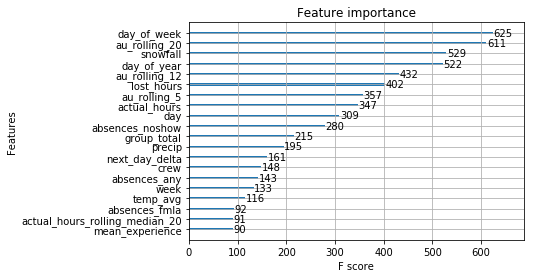

In [61]:
xgb.plot_importance(gbm, max_num_features=20)

#### XGBoost Testing

In [21]:
ypred = gbm.predict(xgb.DMatrix(df_test))

In [22]:
ypred.max()

17.406261

#### SHAP

In [50]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(df_train)

In [54]:
# visualize a prediction's explanation
shap_index = 5000
shap.force_plot(explainer.expected_value, shap_values[shap_index,:], df_train.iloc[shap_index,:])

In [57]:
slice_start = 5000
slice_end = 5100
shap.force_plot(explainer.expected_value, shap_values[slice_start:slice_end], df_train[slice_start:slice_end])

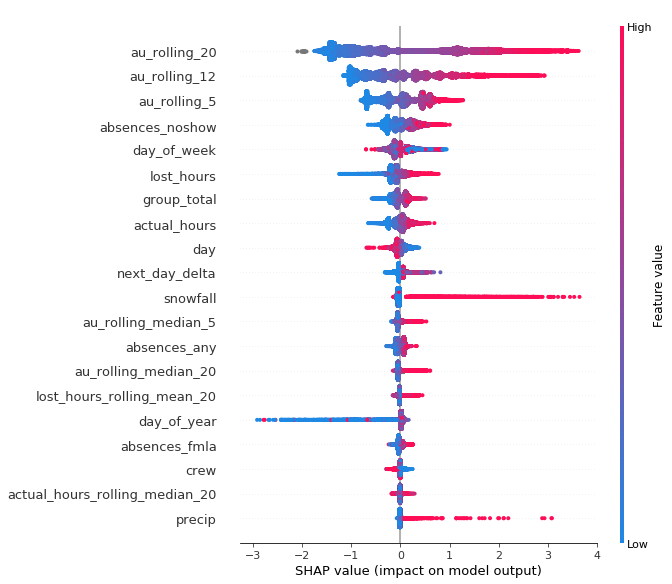

In [62]:
# summarize the effects of all the features
# note inverse day of week
shap.summary_plot(shap_values, df_train)